In [37]:
import os

import torch
import torch.nn as nn
import torch.utils.data as tdata
import torchvision
from torch.nn import functional as F
import matplotlib.pyplot as plt

device = "mps"
torch.manual_seed(127)


# Data import, exploration and pre-processing

In [38]:
class RoadsDataset(tdata.Dataset):
    root: str
    num_images: int
    images: list[torch.Tensor]
    gt_images: list[torch.Tensor]
    gt_images_one_hot: list[torch.Tensor]

    def __init__(self, root: str, num_images=20, transform=None, target_transform=None):
        self.root = root
        self.transform = transform
        self.target_transform = target_transform
        self.num_images = num_images
        assert 10 <= num_images <= 100
        self.images = []
        self.gt_images = []
        self.gt_images_one_hot = []
        for i in range(num_images):
            image_path = os.path.join(self.root, "images/satImage_%.3d.png" % (i + 1))
            img = torchvision.io.read_image(image_path).type(torch.float32).to(device)
            img = img.to(device)
            img /= 255.0
            self.images.append(img)
            gt_image_path = os.path.join(
                self.root, "groundtruth/satImage_%.3d.png" % (i + 1)
            )
            gt_image = torchvision.io.read_image(gt_image_path)
            gt_image_one_hot = torch.movedim(
                F.one_hot(
                    torch.div(
                        torch.squeeze(gt_image.to(device)),
                        255,
                    ).type(torch.int64),
                    2,
                ),
                2,
                0,
            ).to(dtype=torch.float32)
            self.gt_images.append(gt_image)
            self.gt_images_one_hot.append(gt_image_one_hot)

        print("Loaded {} images from {}".format(num_images, root))

    def __len__(self):
        return self.num_images

    def __getitem__(self, item: int) -> tuple[torch.Tensor, torch.Tensor]:
        if self.transform:
            image = self.transform(self.images[item])
        else:
            image = self.images[item]

        if self.target_transform:
            gt_image_one_hot = self.target_transform(self.gt_images_one_hot[item])
        else:
            gt_image_one_hot = self.gt_images_one_hot[item]

        return image, gt_image_one_hot



In [39]:
training_data = RoadsDataset(root="data/training", num_images=10)
training_dataloader = tdata.DataLoader(training_data, batch_size=5, shuffle=True)

Loaded 10 images from data/training


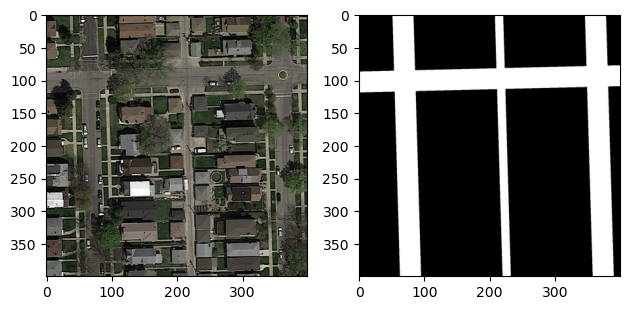

In [40]:
index = torch.randint(0, len(training_data), (1,)).item()
image = training_data.images[index].to(device="cpu")
gt_image = training_data.gt_images[index].to(device="cpu")
plt.subplot(121)
plt.imshow(torch.movedim(image, 0, 2))
plt.subplot(122)
plt.imshow(torch.movedim(gt_image,0,2), cmap="gray")
plt.tight_layout()

# UNet model

In [72]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2), DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(
            in_channels, in_channels // 2, kernel_size=2, stride=2
        )
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        # diffY = x2.size()[2] - x1.size()[2]
        # diffX = x2.size()[3] - x1.size()[3]
        # x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        return self.softmax(self.conv(x))


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super().__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)
        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


unet_model = UNet(n_channels=3, n_classes=2).to(device)

# Model training

In [73]:
loss_fun = nn.BCELoss()
optimizer = torch.optim.Adam(unet_model.parameters(), lr=1e-3)


def train(dataloader: tdata.DataLoader, model: nn.Module, loss_fun, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch_num, (X_batch, Y_batch) in enumerate(dataloader):
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
        # Compute prediction error
        pred = model(X_batch)
        loss = loss_fun(pred, Y_batch)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss, current = loss.item(), (batch_num + 1) * len(X_batch)
        print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


epochs = 3
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(training_dataloader, unet_model, loss_fun, optimizer)

print("Done training!")
torch.save(unet_model.state_dict(), "unet_model2.pth")
print("Saved PyTorch Model State to unet_model2.pth")


Epoch 1
-------------------------------
loss: 0.722471  [    5/   10]
loss: 0.773570  [   10/   10]
Epoch 2
-------------------------------
loss: 0.712521  [    5/   10]
loss: 0.702733  [   10/   10]
Epoch 3
-------------------------------
loss: 0.699124  [    5/   10]
loss: 0.697493  [   10/   10]
Done training!
Saved PyTorch Model State to unet_model.pth


In [74]:
unet_model = UNet(3, 2).to(device)
unet_model.load_state_dict(torch.load("unet_model2.pth"))

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
 

Text(0.5, 1.0, 'Prediction')

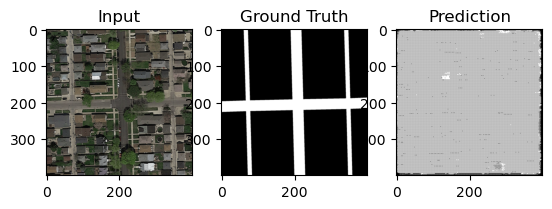

In [75]:
unet_model.eval()
X, Y = training_data.images[0], training_data.gt_images[0]
X = X.to(device)
Y = Y.to(device)
with torch.no_grad():
    Y_pred = torch.unsqueeze(
        torch.argmax(torch.squeeze(unet_model(torch.unsqueeze(X, 0))), dim=0), 0
    )

plt.subplot(1, 3, 1)
plt.imshow(torch.movedim(X, 0, -1).to("cpu"))
plt.title("Input")
plt.subplot(1, 3, 2)
plt.imshow(torch.movedim(Y, 0, 2).to("cpu"), cmap="gray")
plt.title("Ground Truth")
plt.subplot(1, 3, 3)
plt.imshow(torch.movedim(Y_pred, 0, 2).to(device="cpu"), cmap="gray")
plt.title("Prediction")


In [76]:
print(Y_pred.dtype, Y.dtype, X.dtype)
Y_pred
print(torch.min(Y_pred).item(), torch.max(Y_pred).item())
print(torch.min(Y).item(), torch.max(Y).item())
print(Y_pred == 1)

torch.int64 torch.uint8 torch.float32
0 0
0 0
tensor([[[ True, False,  True,  ...,  True, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [ True, False, False,  ..., False, False, False]]], device='mps:0')


In [70]:
Y_pred.device

device(type='mps', index=0)